In [1]:
import math
import importlib

import pickle
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ax import Client, RangeParameterConfig

from botorch.models import SingleTaskGP
from botorch.acquisition import qLogExpectedImprovement, qMaxValueEntropy

from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.priors import GammaPrior

from src.ax_helper import get_full_strategy
from src import GPVisualiser, ax_helper
from src.ax_helper import get_guess_coords
import logging
from src.ax_helper import silence_ax_client, get_full_strategy
from src.toy_functions import Hartmann6D
import pickle

silence_ax_client()


-0.0 -0.9874311636230129


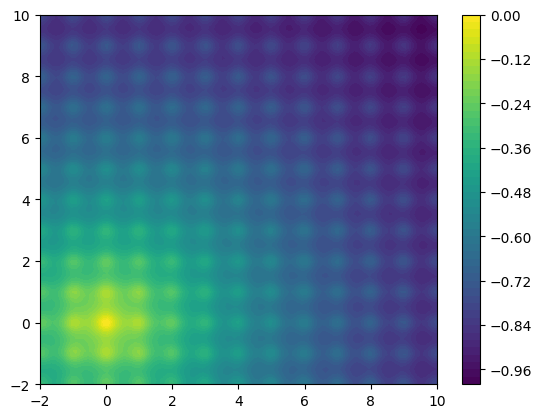

In [2]:
range_parameters = [
    RangeParameterConfig(
        name="x1", parameter_type="float", bounds=(-2, 10)
    ),
    RangeParameterConfig(
        name="x2", parameter_type="float", bounds=(-2, 10)
    )
]

metric_name = "response"
dim_names = ["x1", "x2"]


def test_function(x1, x2):
    # Ackley function (commonly used for optimization benchmarks)
    a = 20
    b = 0.2
    c = 2 * math.pi
    sum_sq = 0.5 * (x1**2 + x2**2)
    cos_comp = 0.5 * (math.cos(c * x1) + math.cos(c * x2))
    ackley_grid = -a * math.exp(-b * math.sqrt(sum_sq)) - math.exp(cos_comp) + a + math.exp(1)
    standardized = (ackley_grid-0.2434339681166695)/(19.3680592868830)
    return -standardized


import numpy as np
grid = np.linspace(-2, 10, 101)
x1_grid, x2_grid = np.meshgrid(grid, grid)
ackley_vals = np.array([test_function(x1, x2) for x1, x2 in zip(x1_grid.ravel(), x2_grid.ravel())]).reshape(x1_grid.shape)
ackley_vals
print(ackley_vals.max(), ackley_vals.min())


plt.contourf(x1_grid, x2_grid, ackley_vals, levels=60, cmap="viridis")
plt.colorbar()

# Sobol
The default initial parameter exploration strategy uses SOBOL algorithm:

### log param sobol:

In [3]:
import logging
import builtins

class SuppressInfoPrefix(logging.Filter):
    def filter(self, record):
        return not record.getMessage().startswith('[INFO')

# Create and register the filter globally (all loggers)
_filter = SuppressInfoPrefix()
root_logger = logging.getLogger()
root_logger.addFilter(_filter)
for handler in root_logger.handlers:
    handler.addFilter(_filter)

# Also add to any already-created loggers
for logger_name, lg in logging.root.manager.loggerDict.items():
    if isinstance(lg, logging.Logger):
        lg.addFilter(_filter)
        for h in lg.handlers:
            h.addFilter(_filter)

# Optional: suppress bare print() lines starting with '[INFO'
_original_print = builtins.print
def filtered_print(*args, **kwargs):
    if args and isinstance(args[0], str) and args[0].startswith('[INFO'):
        return
    _original_print(*args, **kwargs)

builtins.print = filtered_print


   trial_name         x0         x1
0         0_0  10.000000  10.000000
1         1_0  63.434791  13.465105
2         2_0   9.209849   2.539975
3         3_0   1.081319  38.507929
4         4_0  15.827761   6.691992
5         5_0  31.360407  59.565917
6         6_0   1.854779   3.186287
7         7_0   5.365309  28.025873
8         8_0  32.046315   1.598259
9         9_0  42.895326  42.663354
10       10_0   4.008011   8.056808
11       11_0   2.462564  12.160002
12       12_0  23.618880   2.110817
13       13_0  11.924709  18.810375
14       14_0   1.435330   1.005070
15       15_0   6.870881  88.801243
16       16_0  85.035867   5.069853
17       17_0  95.656822  81.232754
18       18_0   5.657529   4.797185
19       19_0   1.758666  22.889685
20       20_0  10.504279   1.270602
21       21_0  19.352582  11.503082
22       22_0   2.809730   1.930422
23       23_0   3.545028  53.952260
24       24_0  51.890120   9.807235
25       25_0  39.089116  25.652354
26       26_0   4.705010   1

<Axes: xlabel='x0', ylabel='x1'>

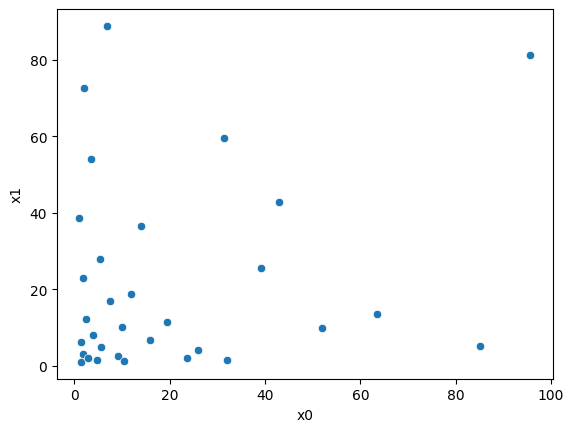

In [4]:

client = Client()
client.verbose_logging = False
#client.verbose_logging = False

client.configure_experiment(
    name="batch_bo_test",
    parameters=[
        RangeParameterConfig(
            name=f"x{i}",
            bounds=(1, 100),
            parameter_type="float",
            scaling = 'log',
        ) for i in range(len(dim_names))
    ],
)

client.configure_optimization(objective="-loss")
client.get_next_trials(max_trials=32)
coords = get_guess_coords(client)
print(coords)
sns.scatterplot(data=coords, x="x0", y="x1")

Low value oversampling is inline with logarithmic distribution.

**Considering that we expect overexpression to be optimal when compared to underexpression, Sobol should be run on a linear scale**.

### linear parameters sobol

<Axes: xlabel='x1', ylabel='x2'>

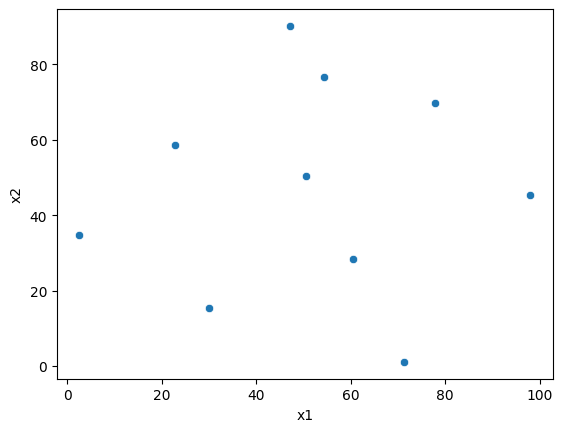

In [5]:
client = Client()

parameters=[
    RangeParameterConfig(
        name=dim,
        bounds=(1, 100),
        parameter_type="float",
        # scaling = 'log',
    ) for dim in dim_names
]


client.configure_experiment(
    name="batch_bo_test",
    parameters=parameters
)

client.configure_optimization(objective="response")
client.get_next_trials(max_trials=10)

coords = get_guess_coords(client)

sns.scatterplot(data=coords, x="x1", y="x2")

A nice and informative initial guess grid is formed

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\botorch\models\utils\assorted.py:270: InputDataWarning:

Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.



(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'GP along x1'}, xlabel='x1', ylabel='response'>,
        <Axes: title={'center': 'GP along x2'}, xlabel='x2', ylabel='response'>],
       dtype=object))

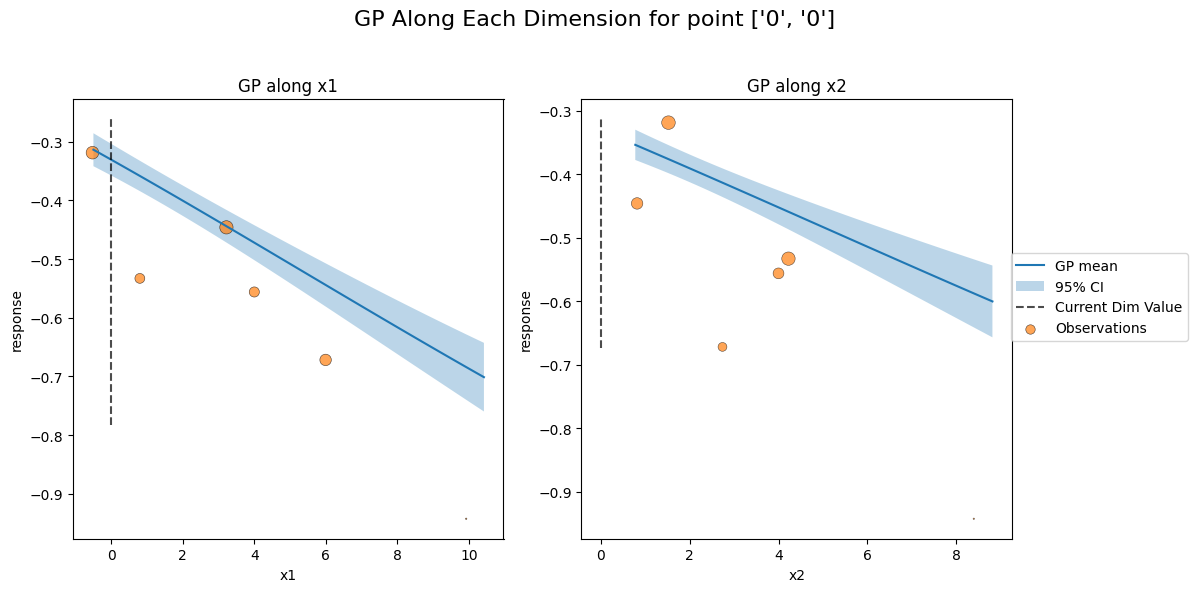

In [6]:
client = Client()

client.configure_experiment(parameters=range_parameters)


client.configure_optimization(objective=metric_name)

from src import ax_helper
importlib.reload(ax_helper)

batch_handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=6, range_params=range_parameters)
batch_handler.get_next_batch()
batch_handler.complete_all_pending()

df = ax_helper.get_obs_from_client(client, response_col='response')
plotter = GPVisualiser.GPVisualiserMatplotlib(SingleTaskGP, df, dim_names, 'response', parameters)
plotter.plot_all([0,0])

In [7]:
df

,trial_name,x1,x2,response
0,0_0,4.000000,4.000000,-0.556069
1,1_0,3.220134,0.813807,-0.445937
2,2_0,9.923834,8.399894,-0.942483
3,3_0,5.993325,2.737700,-0.671858
4,4_0,0.799836,4.224169,-0.532910
5,5_0,-0.524798,1.520738,-0.318715


# Custom Botorch model

### Define the GP surrogate


MES (max value entropy search) should be the ideal choice for acquisition functions because:
* It can handle noise.
* Samples in a manner to best define the optimum.
    * Consequently, will rarely repeat exactly identical samplings.
* Has a cost/fidelity setting

In [8]:
client = Client()
generation_strategy = get_full_strategy(gp=SingleTaskGP, acqf_class=qLogExpectedImprovement)
client.configure_experiment(parameters=range_parameters)

client.set_generation_strategy(
    generation_strategy=generation_strategy,
)
client.configure_optimization(objective=metric_name)

from src import ax_helper
importlib.reload(ax_helper)

batch_handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=1, range_params=range_parameters)
batch_handler.get_next_batch()
batch_handler.complete_all_pending()

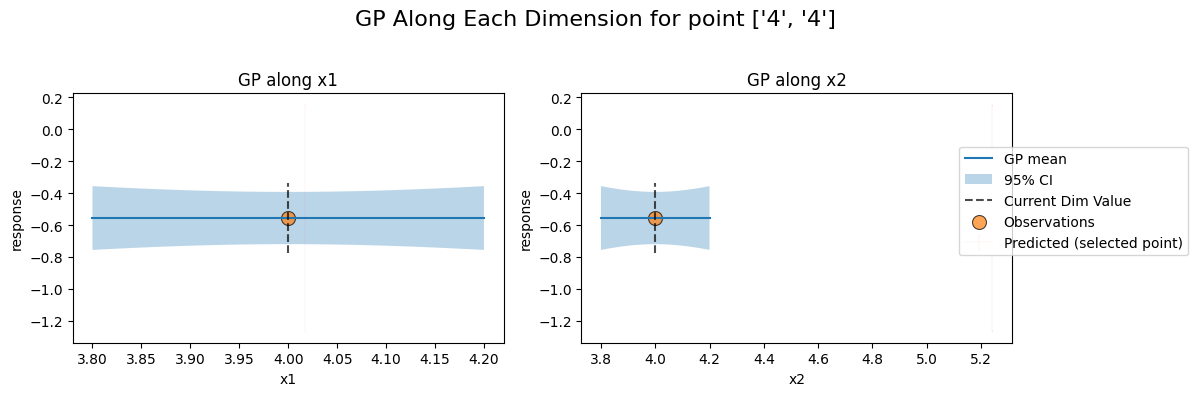

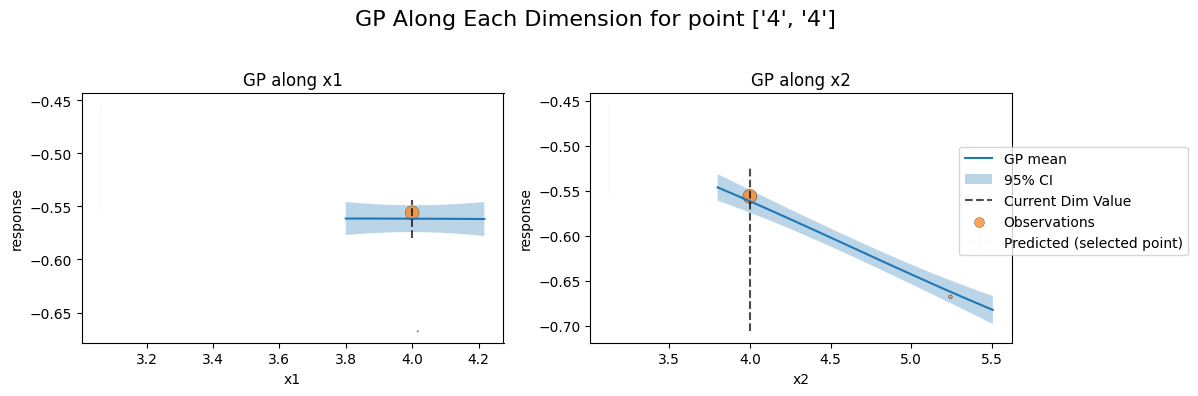

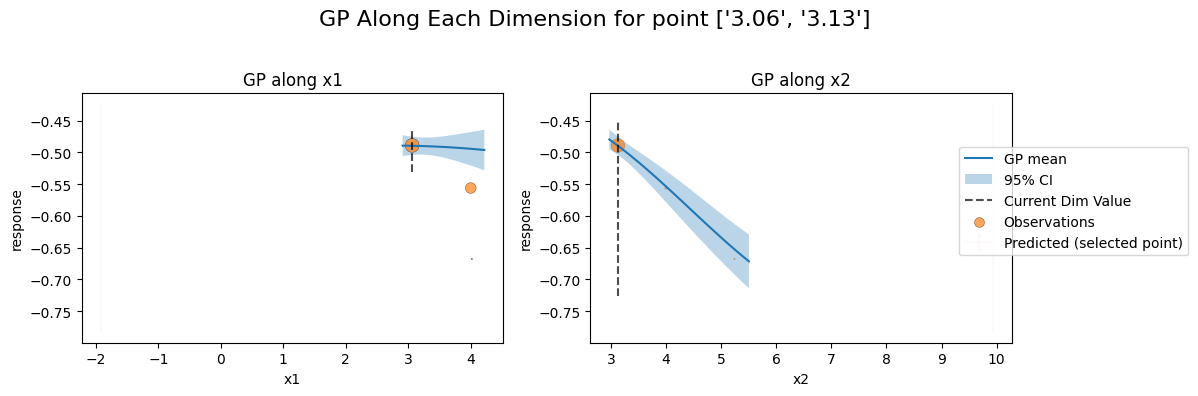

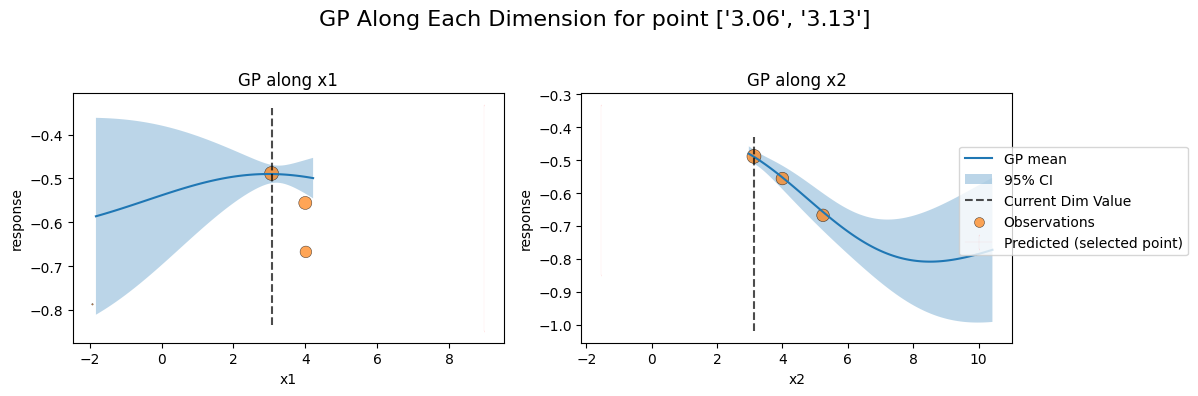

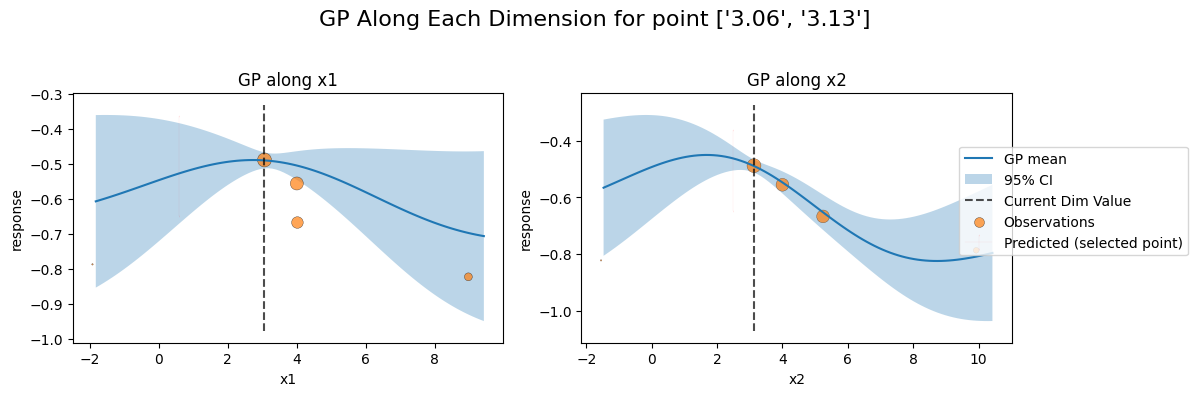

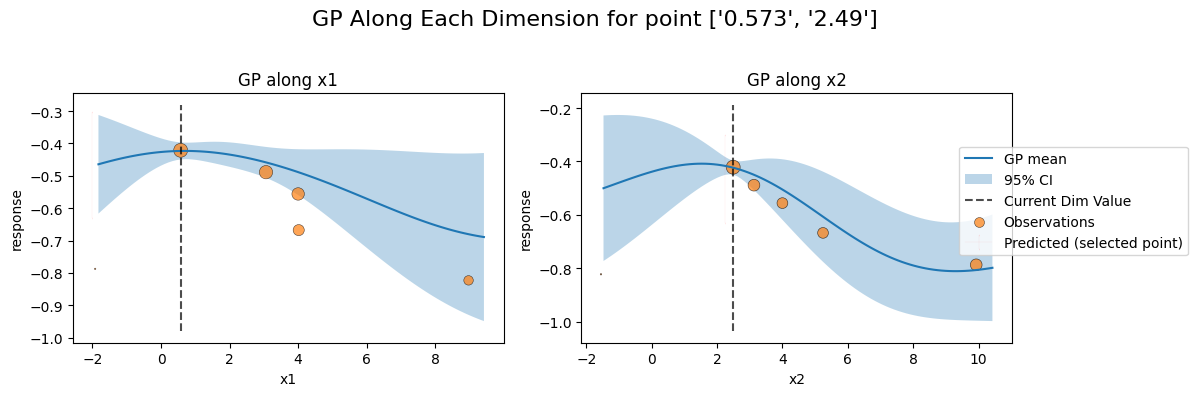

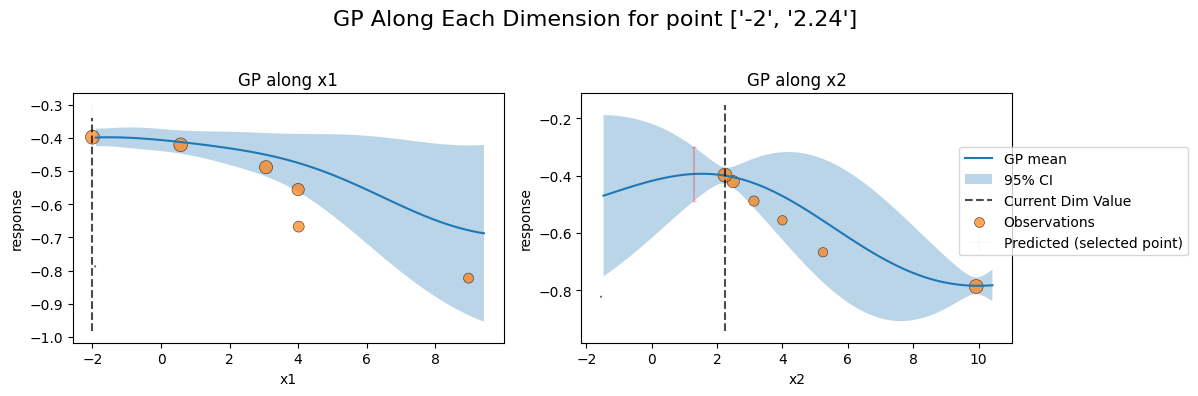

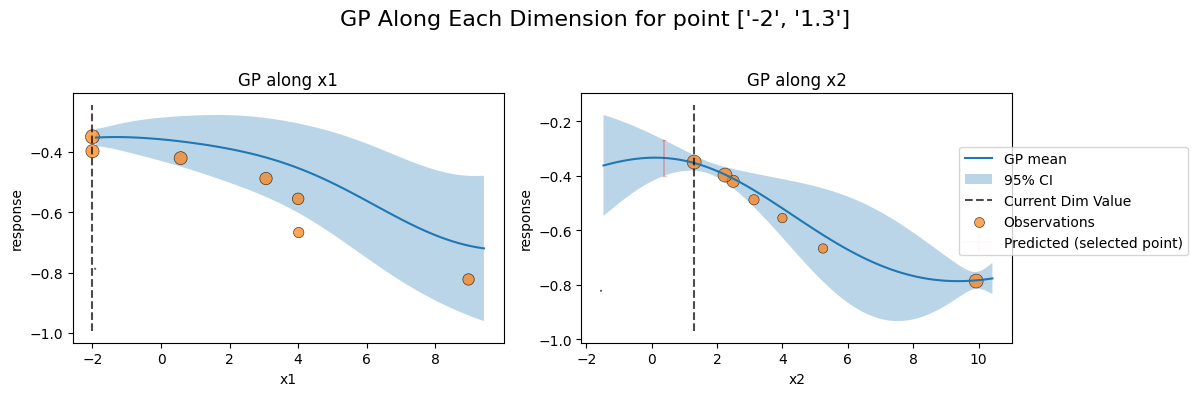

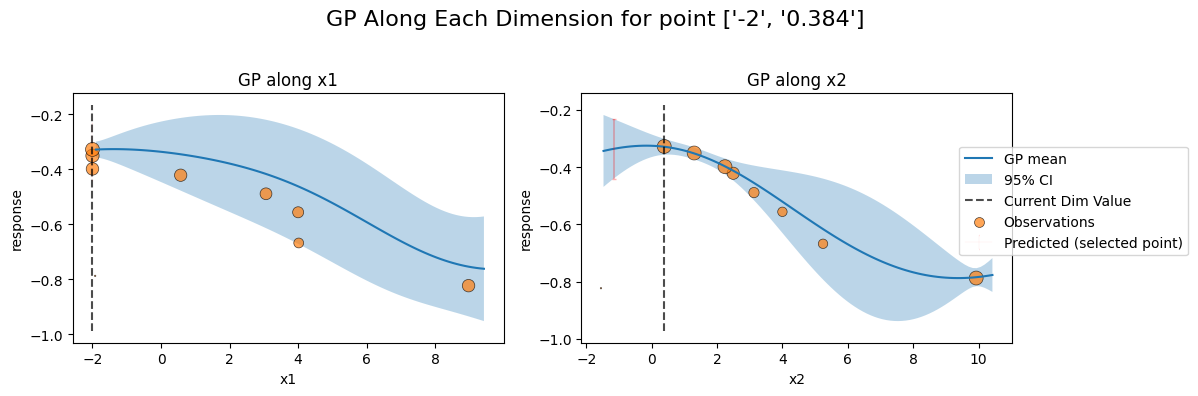

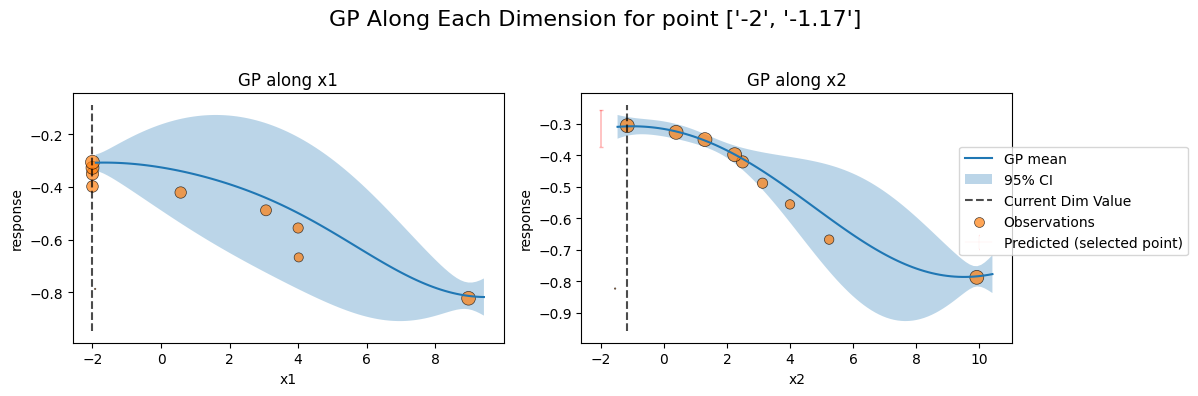

In [9]:
import matplotlib.pyplot as plt
for _ in range(10):
    batch_handler.get_next_batch()

    batch_handler.plot_GP(SingleTaskGP, figsize=(12, 4))
    batch_handler.complete_all_pending()


In [10]:
df

,trial_name,x1,x2,response
0,0_0,4.000000,4.000000,-0.556069
1,1_0,3.220134,0.813807,-0.445937
2,2_0,9.923834,8.399894,-0.942483
3,3_0,5.993325,2.737700,-0.671858
4,4_0,0.799836,4.224169,-0.532910
5,5_0,-0.524798,1.520738,-0.318715


# Technical repeats
Knowing that real biological data posses significant significant noise, the model has to be robust enough to handle technical repeats

In [11]:
range_parameters = [
    RangeParameterConfig(
        name="x1", parameter_type="float", bounds=(-2, 10)
    )
]

metric_name = "response"
dim_names = ["x1"]

def test_function(x1):
    # Original: y = -((x1 - 2) ** 2) + 10  -> range on [-2,10] is [-54, 10]
    y = -((x1 - 2) ** 2) + 10
    return (y + 54) / 64  # scale to [0,1]


noise_fn = lambda x, y: y + np.random.normal(0, 1)

def plot_test():
    plt.plot(np.linspace(-2, 10, 100), [test_function(x) for x in np.linspace(-2, 10, 100)], color='black', label='True function')

In [12]:
from src.ax_helper import SequentialRuns
SequentialRuns

src.ax_helper.SequentialRuns

In [32]:
from src import ax_helper
importlib.reload(ax_helper)

tester = ax_helper.SequentialRuns(test_function, range_parameters, dim_names, metric_name)

runs = tester.run(
    SingleTaskGP,
    n_runs=4,
    technical_repeats=2,
    batch_size=3,
    noise_fn=noise_fn,
    plot_each=False,
)
#runs.plot_GP(SingleTaskGP, figsize=(8, 4))
#plot_test()

runs.get_batch_observations()

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



,trial_name,x1,response,trial_index
0,0_0,4.000000,0.937500,0
1,1_0,0.650298,0.971536,1
2,2_0,9.053159,0.222702,2
3,0_0,4.000000,0.937500,0
4,1_0,0.650298,0.971536,1
5,2_0,9.053159,0.222702,2
6,6_0,2.258592,0.998955,6
7,7_0,-2.000000,0.750000,7
8,8_0,-0.866670,0.871597,8
9,6_0,2.258592,0.998955,6


* This simple Kernel is incapable of encompassing noise. Consequently, it overfits.
* Technical repeats slightly improve the situation, however they do not fix the problem.

### GP + noise

Simply adding a lot of noise, significantly improves the fit.
 

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



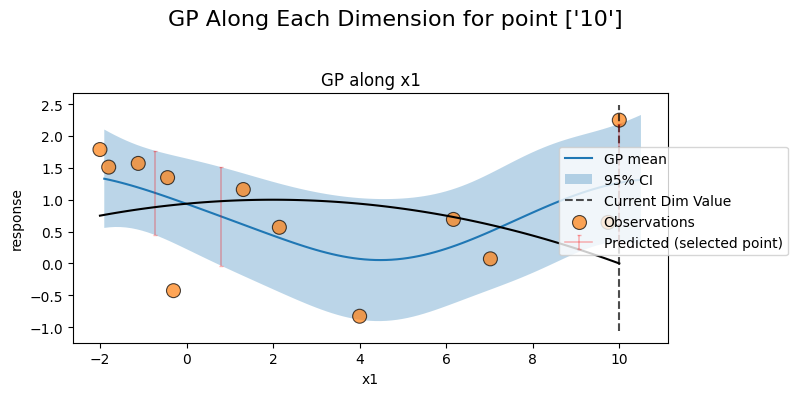

In [14]:
from src.model_generation import GammaNoiseSGP


runs = tester.run(
    GammaNoiseSGP,
    n_runs=4,
    technical_repeats=1,
    batch_size=3,
    noise_fn=noise_fn,
    plot_each=False,
).plot_GP(GammaNoiseSGP, figsize=(8, 4))


plot_test()

* Introducing a noise channel significantly improves fit performance, even if no technical repeats are provided to narrow down the mean.
However,a heteroscedastic, or at least technical repeat aware noise kernel would be preferable.

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



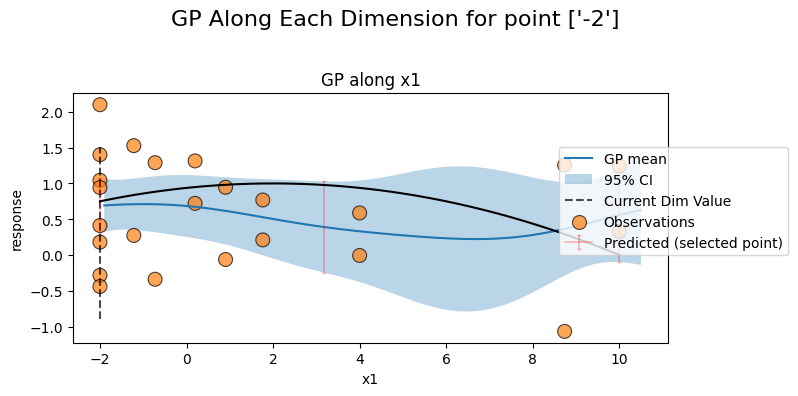

In [15]:
runs = tester.run(GammaNoiseSGP, n_runs=4, technical_repeats=2, batch_size=3, noise_fn=noise_fn, plot_each=False).plot_GP(GammaNoiseSGP, figsize=(8, 4))
plot_test()

It appears that technical repeats significantly improve noise resolution for the kernel, however, more quantitative tests are required.

# Heteroscedastic noise

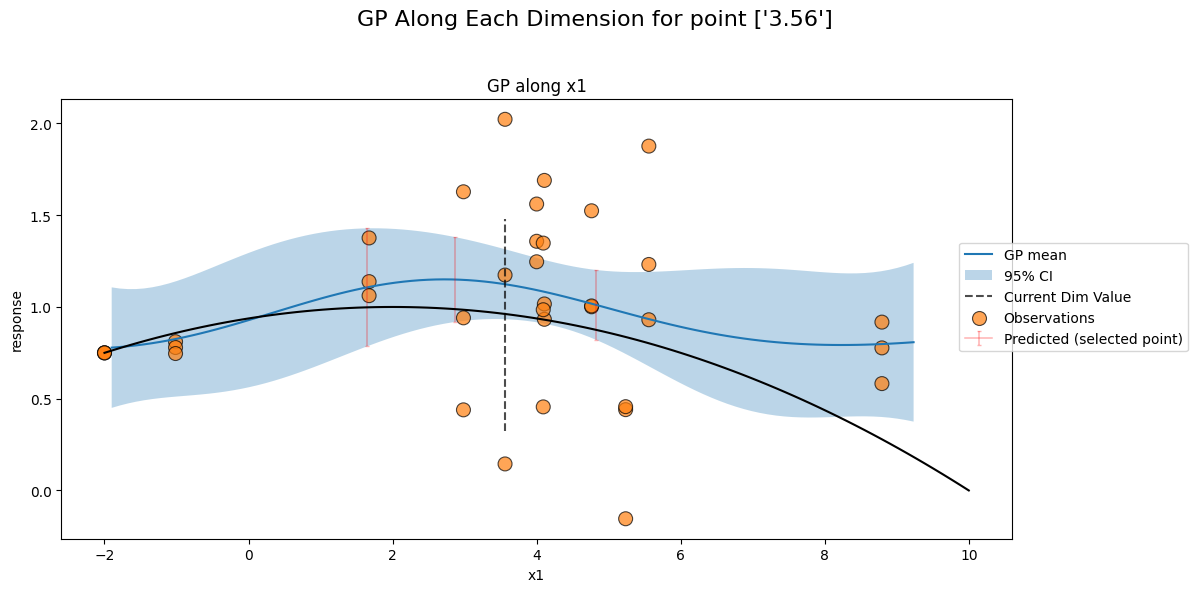

In [16]:
def noise_fn_low(x, y= None):
    return y + np.random.normal(0, 1)*(x['x1']+2)/12


runs = tester.run(GammaNoiseSGP, n_runs=4, technical_repeats=3, batch_size=3, noise_fn=noise_fn_low, plot_each=False)
runs.plot_GP(GammaNoiseSGP, figsize=(12, 6))
plot_test()

* The white noise kernel is unable to accommodate linear heteroscedastic noise.

## Technical repeat adaptive kernel

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning:

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.



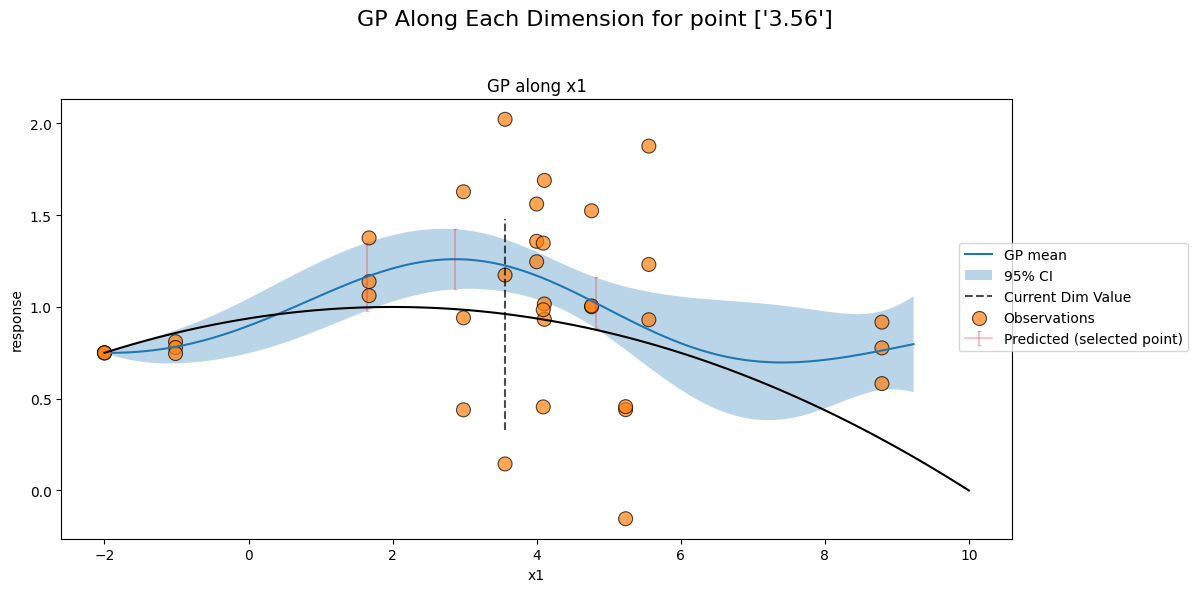

In [17]:
from src.model_generation import HeteroNoiseSGP, HeteroWhiteSGP
        
runs.plot_GP(HeteroNoiseSGP, figsize=(12, 6))
plot_test()

* Fitting a gp to pre-investigated data appear perform quite badly 

## Heteroscedastic + fixed white noise

tensor([0.1773, 0.1860, 0.1819, 0.1773, 0.1773, 0.1860, 0.1860, 0.1819, 0.1819,
        0.0355, 0.5012, 0.0500, 0.0355, 0.0355, 0.5012, 0.5012, 0.0500, 0.0500,
        0.4328, 0.3185, 0.9583, 0.4328, 0.4328, 0.3185, 0.3185, 0.9583, 0.9583,
        0.4666, 0.3659, 0.6144, 0.4666, 0.4666, 0.3659, 0.3659, 0.6144, 0.6144],
       dtype=torch.float64, grad_fn=<AddBackward0>)


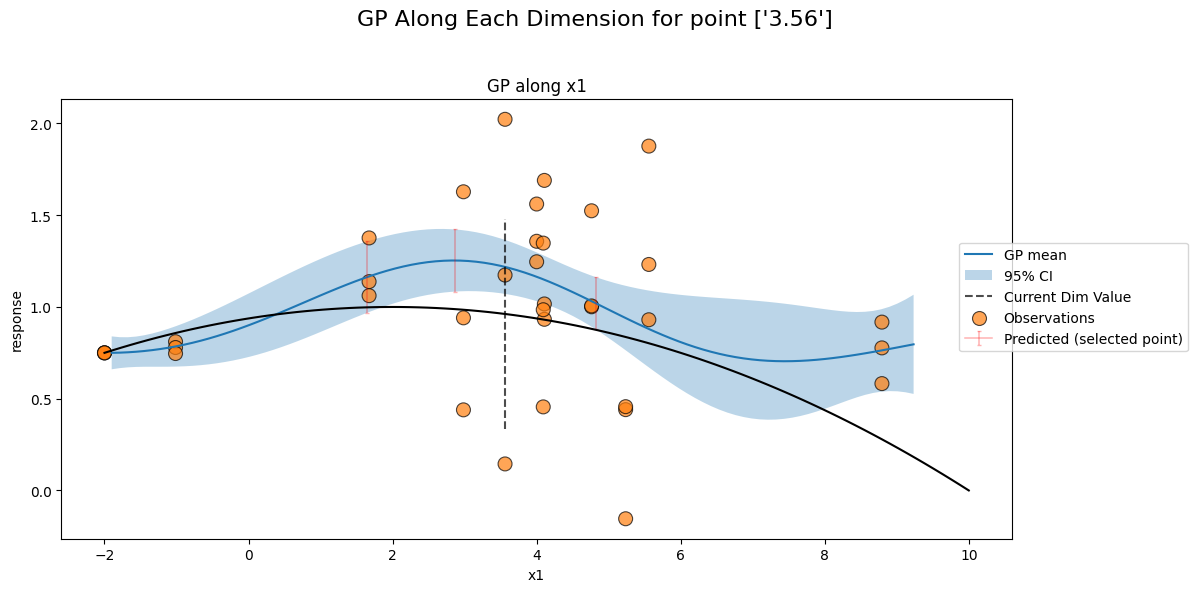

In [18]:


runs.plot_GP(HeteroWhiteSGP, figsize=(12, 6))
plot_test()

Much better performance when data is acquired during the run.

# Quantification of Noise, technical repeats, and batch size.

6 dimensional hartman function is used for evaluation, due to its high dimensionality, multiple local optima, ridges and non-linear interactions.

In [19]:


save_dir = "data/bayes_sim/"
h6 = Hartmann6D().eval_at

_h6_x_opt = torch.tensor([0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573])
h_6_max = [float(h6(*_h6_x_opt)) for _ in range(10000)]
h_6_max

[3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,


In [20]:
hartmann6_range_parameters = [
    RangeParameterConfig(name=f"x{i+1}", parameter_type="float", bounds=(0.0, 1.0))
    for i in range(6)
]
dim_names_h6 = [rp.name for rp in hartmann6_range_parameters]

tester = SequentialRuns(h6, hartmann6_range_parameters, dim_names_h6, metric_name)
tester

## Sequential runs no noise

In [21]:
from src import model_generation

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], dtype=torch.float64, grad_fn=<AddBackward0>)


c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning:

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.



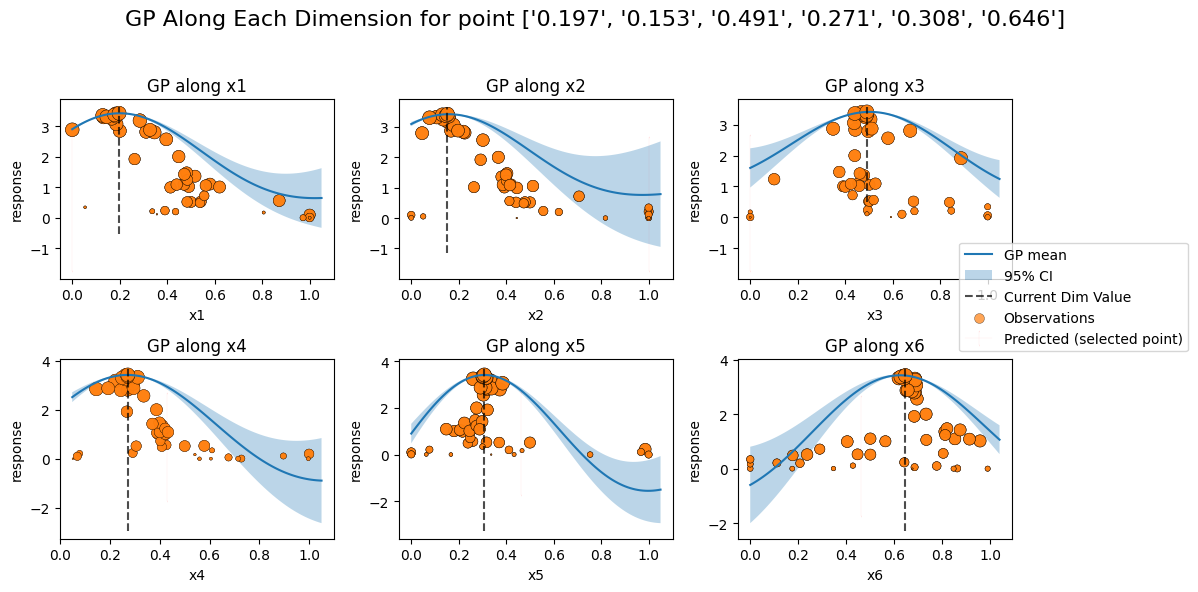

In [22]:
def noise_fn(x, y):
    return y

save_dir = "data/bayes_sim/"
runs = tester.run(HeteroWhiteSGP, n_runs=50, technical_repeats=3, batch_size=1, noise_fn=noise_fn, plot_each=False)
runs.plot_GP(HeteroWhiteSGP)

## Noise vs technical repeats for sequential Single task GP
* SingleTaskGP
* qLogExpectedImprovement
* 100 sequential runs
* range [0, 3.4]
* Noise [0,2]
* Technical repeats: [1,8]

In [23]:

import src.stats_eval_helper as seh
importlib .reload(seh)
data_path = r"data\bayes_sim\HeteroWhite_09_29.pkl"

explo_dict:dict = pickle.load(open(data_path, "rb"))


def get_mean_std(df, x_columns):
    all_cols =  ['response', 'y_true', 'error']
  
    df = df[x_columns +all_cols].groupby(all_cols).agg(['mean', 'std']).reset_index()
    print(df)

for id, df in explo_dict.items():
    print(id, len(df))
    get_mean_std(df, dim_names_h6)



(1, np.float64(0.0), 'again_1') 101
    response    y_true error        x1            x2            x3      \
                                  mean std      mean std      mean std   
0   0.000002  0.000002   0.0  0.988436 NaN  0.000000 NaN  1.000000 NaN   
1   0.000002  0.000002   0.0  1.000000 NaN  0.000000 NaN  0.000000 NaN   
2   0.000005  0.000005   0.0  1.000000 NaN  0.241258 NaN  0.000000 NaN   
3   0.000005  0.000005   0.0  1.000000 NaN  1.000000 NaN  0.000000 NaN   
4   0.000011  0.000011   0.0  1.000000 NaN  0.000000 NaN  1.000000 NaN   
..       ...       ...   ...       ...  ..       ...  ..       ...  ..   
95  3.390132  3.390132   0.0  0.196407 NaN  0.159327 NaN  0.472764 NaN   
96  3.393893  3.393893   0.0  0.193871 NaN  0.155757 NaN  0.477628 NaN   
97  3.398204  3.398204   0.0  0.194205 NaN  0.158543 NaN  0.470459 NaN   
98  3.401757  3.401757   0.0  0.193820 NaN  0.160470 NaN  0.465255 NaN   
99  3.412324  3.412324   0.0  0.199499 NaN  0.155108 NaN  0.472289 NaN   

 

In [24]:
def get_top_deciles(explo_dict):
    return {id:ax_helper.get_above_percentile(df, 3.4, .9) for id, df in explo_dict.items()}

get_top_deciles(explo_dict)
hits = seh.hit_stats(get_top_deciles(explo_dict))
hits.rename(columns={'level_2': 'run_repeat', 'level_0': 'tech_repeats', 'level_1': 'noise'}, inplace=True)
hits["noise"] = hits["noise"].round(2)
hits

,tech_repeats,noise,run_repeat,TP_index,FP_index,TN_index,FN_index,TP,FP,TN,FN,Precision,Recall,Specificity,Accuracy,F1
0,1,0.0,again_1,"[22, 25, 27, 28, 29, 30, 32, 34, 36, 38, 41, 4...",[],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],18,0,83,0,1.0,1.0,1.0,1.0,1.0
1,1,0.0,again_2,"[28, 32, 33, 37, 38, 39, 40, 41, 48, 53, 54, 5...",[],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],20,0,81,0,1.0,1.0,1.0,1.0,1.0
2,1,0.0,again_3,"[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 3...",[],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],19,0,82,0,1.0,1.0,1.0,1.0,1.0
3,1,0.0,again_4,"[22, 23, 26, 27, 29, 30, 31, 32, 35, 36, 38, 3...",[],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],24,0,77,0,1.0,1.0,1.0,1.0,1.0
4,1,0.0,again_5,"[25, 26, 27, 32, 33, 35, 41, 47, 56, 57, 69, 7...",[],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],17,0,84,0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,9,1.1,again_2,[],"[17, 19, 23, 24, 26, 28, 30, 31, 32, 39, 44, 4...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],0,29,72,0,0.0,0.0,0.712871,0.712871,0.0
176,9,1.1,again_3,[],[42],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],0,1,100,0,0.0,0.0,0.990099,0.990099,0.0
177,9,1.1,again_4,[],[],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],0,0,21,0,0.0,0.0,1.0,1.0,0.0
178,9,1.1,again_5,[],[],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],0,0,95,0,0.0,0.0,1.0,1.0,0.0


In [25]:
# Series type and underlying element types
print("Series type:", type(hits["TP_index"]))
print("Series dtype:", hits["TP_index"].dtype)
print("Unique element types:", hits["TP_index"].map(type).unique())
# Peek at first element
print("First element type:", type(hits["TP_index"].iloc[0]))
print("First element value:", hits["TP_index"].iloc[0])

Series type: <class 'pandas.core.series.Series'>
Series dtype: object
Unique element types: [<class 'list'>]
First element type: <class 'list'>
First element value: [22, 25, 27, 28, 29, 30, 32, 34, 36, 38, 41, 43, 49, 55, 78, 81, 90, 99]


In [26]:
hits["first_hit"] = hits["TP_index"].apply(lambda v: v[0] if isinstance(v, (list, tuple)) and len(v) > 0 else pd.NA)
hits
hits.iloc[150, 5]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 39,
 40,
 41,
 42,
 49,
 50,
 51,
 54,
 57,
 59,
 60,
 64,
 65,
 66,
 68,
 72,
 73,
 84,
 86,
 92,
 99,
 100]

<Axes: xlabel='noise', ylabel='F1'>

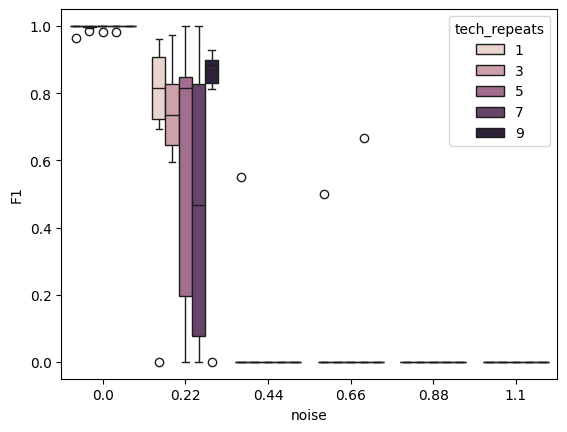

In [27]:
sns.boxplot(data=hits, x='noise', y='F1', hue ='tech_repeats')

<Axes: xlabel='tech_repeats', ylabel='Specificity'>

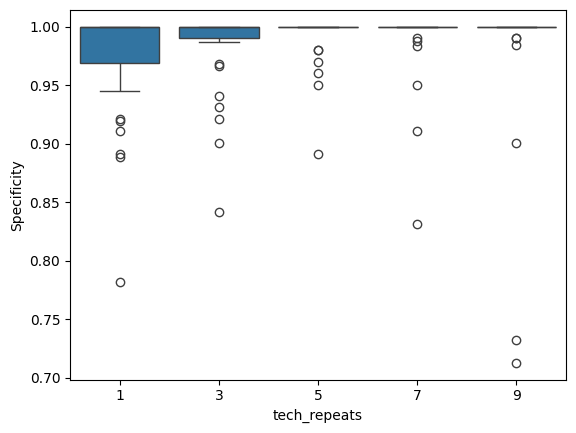

In [28]:
sns.boxplot(data=hits, x='tech_repeats', y='Specificity')

<Axes: xlabel='noise', ylabel='Accuracy'>

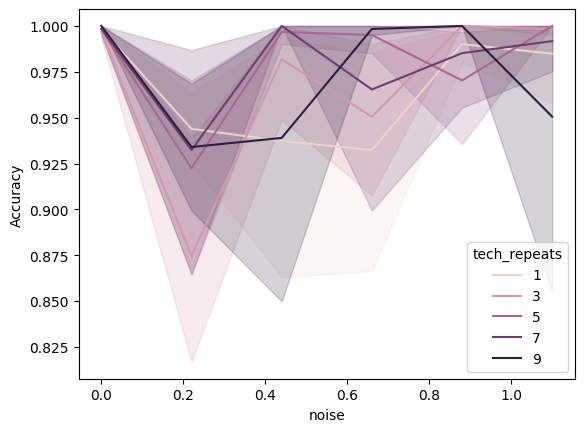

In [29]:
sns.lineplot(data=hits, x="noise", hue="tech_repeats", y='Accuracy')

## Noise vs technical repeats for sequential Single task GP with Gamma noise
* Gamma noise
* qLogExpectedImprovement
* 100 sequential runs
* range [0, 3.4]
* Noise [0,2]
* Technical repeats: [1,8]

In [30]:
explo_dict:dict = pickle.load(open(save_dir + r"GammaNoiseSGP_noise_vs_t_repeats.pkl", "rb"))
df = seh.hit_stats(get_top_deciles(explo_dict))
sns.lineplot(data=df, x="noise", hue="tech_repeats", y='Accuracy')

ValueError: Could not interpret value `noise` for `x`. An entry with this name does not appear in `data`.